In [1]:
# Import libraries
import os
import sys
sys.path.append('../')
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=6
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from econml.sklearn_extensions.linear_model import WeightedLassoCV
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.metrics as sme
import sklearn.feature_selection as skf
import sklearn.ensemble as ske
import sklearn.utils as sku
import sklearn.decomposition as skd
import sklearn.neural_network as skn
from celer import GroupLassoCV
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util as util
from scipy.spatial import cKDTree
import nibabel as nib
import os
import pickle
from torch import nn
from sklearn.exceptions import ConvergenceWarning
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [3]:
# Maybe y should also be scaled? 
# Perhaps a transform would be more effective, or scaling implemented with consistent cross-validation
# Different scaling methods? 
#     This seems most important for noise-sensitive models like LARS. All other use StandardScaler()
# Transformers?
# Model-specific scaling methods?
#     Yes, see above
# Common cross-validation function ✓
#     Use built-in functions wherever possible and `utils.gridsearch_pickparams()` elsewhere
# Quantile loss
# RANSAC
# Data augmentation? (Mixup)
# Data generation? (SMOGN)
# Combine CHH dataset ✓
# Implement CV and test ✓
# Print selected features ✓
# Make magnitude templates
# Sample weights ✓
# Look at segmentations by error ✓ (Appears to have most difference in red nucleus, which includes surrounding (white?) matter for underperforming cases)
# Extract features from current (1:6) eroded ROIs
# Extract features from all ROIs
# Plot segmentation variance against error for each case across all ROIs ✓
# Why does excluding the subthalamic nucleus increase the correlation (r=0.5 -> r=0.6)?
# Best performance with all ROIs: cvn=6, k=1800
# Best performance with ROIs 0:4, excluding STN: cvn=6, k=1800
# Should the pre-operative UPDRS be appended once or to each ROI? ✓
# Plot histogram of features for successful and unsuccessful predictions

In [4]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528_wldd.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','pre op levadopa equivalent dose (mg)','CORNELL ID')
# Find cases with all required scores
subs,pre_imp,post_imp,pre_updrs_off,ledd = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo',
                                                          'pre op levadopa equivalent dose (mg)')
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/phi_o/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
all_rois = False
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X_o/',npy_dir+'R_o/',npy_dir+'K_o/',n_rois,1595,all_rois)

ids = np.asarray(ID_all).astype(int)
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
X_all_c = X_all[c_cases_idx,0:4,:]
K_all_c = K_all[c_cases_idx,0:4,:]
R_all_c = R_all[c_cases_idx,0:4,:]
# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
subsc = subs[s_cases_idx]
pre_imp = pre_imp[s_cases_idx]
post_imp = post_imp[s_cases_idx]
pre_updrs_off = pre_updrs_off[s_cases_idx]
ledd = ledd[s_cases_idx]
per_change = post_imp
# Reshape keys and ROIs
if all_rois == True:
    K_all_cu = np.empty((K_all_c.shape[0],K_all_c.shape[1],K_all_c.shape[2]+1),dtype=object)
    K_all_cu[:,:,:-1] = K_all_c
    K_all_cu[:,:,-1] = 'pre_updrs'
    K = K_all_cu.reshape((K_all_cu.shape[0],K_all_cu.shape[1]*K_all_cu.shape[2]))[0]
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))
else:
    K = K_all_c.reshape((K_all_c.shape[0],K_all_c.shape[1]*K_all_c.shape[2]))[0]
    K = np.append(K,['pre_updrs'],0)
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))


       Unnamed: 0                PRE-OP           Unnamed: 2  \
0      CORNELL ID  Apathy Off (pre-dbs)  Apathy ON (pre-dbs)   
1              67                    na                   13   
2   only Ct data                     na                   na   
3              74                    na                   na   
4              84                    na                   22   
..            ...                   ...                  ...   
87             52                   NaN                  NaN   
88             53                   NaN                  NaN   
89             54                   NaN                  NaN   
90             55                   NaN                  NaN   
91             56                   NaN                  NaN   

             Unnamed: 3          Unnamed: 4    Unnamed: 5  \
0   OFF (pre-dbs updrs)  ON (pre-dbs updrs)  mri (pre-op)   
1                    60                  41      3/9/2020   
2                    43                  12     

In [5]:
scoring = 'r2'
results_bls = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
results_gls = np.zeros_like(per_change)
gerror = np.zeros_like(per_change)
r = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
err_var = np.zeros_like(per_change)
alphas = np.logspace(-4,4,100)
Ks = []
Kstg = []
w = []
wg = []
pcases = []
pscores = []
s = []

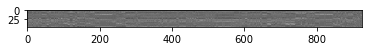

Lasso predicts 0.44 for case 67.0 with 0.48 with regularization 0.0003465307963174154 with reconstruction error 0.001017516 maximum error 0.001389737 and neighbor 0.43


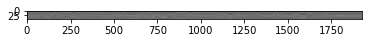

Lasso predicts 0.63 for case 75.0 with 0.97 with regularization 0.005325920339177255 with reconstruction error 0.039177416 maximum error 0.022909528 and neighbor 0.88


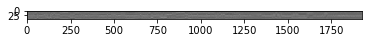

Lasso predicts 0.53 for case 68.0 with 0.75 with regularization 0.002426145972029437 with reconstruction error 0.020159854 maximum error 0.00877015 and neighbor 0.82


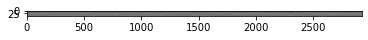

Lasso predicts 0.74 for case 79.0 with 0.66 with regularization 0.01757727242201463 with reconstruction error 0.074489079 maximum error 0.056946497 and neighbor 0.84


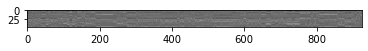

Lasso predicts 1.06 for case 59.0 with 0.74 with regularization 2.1968903304712596e-15 with reconstruction error 0.0 maximum error 0.0 and neighbor 0.69


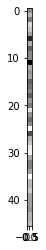

Lasso predicts 0.09 for case 85.0 with 0.15 with regularization 0.0 with reconstruction error 0.476369387 maximum error 0.15509293 and neighbor 0.09


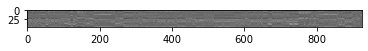

Lasso predicts 0.84 for case 63.0 with 0.85 with regularization 0.0026608329424126997 with reconstruction error 0.019575752 maximum error 0.010377992 and neighbor 0.8


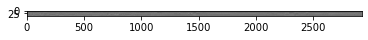

Lasso predicts 0.42 for case 66.0 with 0.53 with regularization 2.0093174975765654e-06 with reconstruction error 1.406e-06 maximum error 8.175e-06 and neighbor 0.3


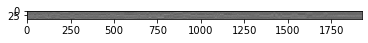

Lasso predicts 0.55 for case 86.0 with 0.5 with regularization 2.475724303925637e-15 with reconstruction error 0.0 maximum error 0.0 and neighbor 0.26


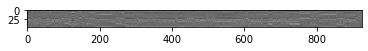

Lasso predicts 0.53 for case 69.0 with 0.49 with regularization 8.575012045460091e-16 with reconstruction error 0.0 maximum error 0.0 and neighbor 0.82


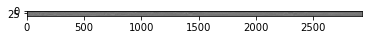

Lasso predicts 0.48 for case 72.0 with 0.26 with regularization 0.002777712819205095 with reconstruction error 0.007625798 maximum error 0.010964174 and neighbor 0.88


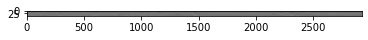

Lasso predicts 0.61 for case 80.0 with 0.52 with regularization 0.011453468682430796 with reconstruction error 0.017573267 maximum error 0.040875916 and neighbor 0.66


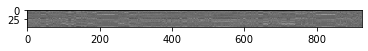

Lasso predicts 0.46 for case 81.0 with 0.19 with regularization 0.0018003438391250895 with reconstruction error 0.003501242 maximum error 0.006681047 and neighbor 0.47


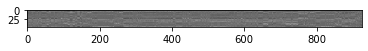

Lasso predicts 0.62 for case 77.0 with 0.56 with regularization 0.0017564229839404494 with reconstruction error 0.002226562 maximum error 0.007172407 and neighbor 0.87


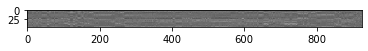

Lasso predicts 0.83 for case 64.0 with 0.66 with regularization 6.2769856975992575e-15 with reconstruction error 0.001386302 maximum error 0.000824005 and neighbor 0.5


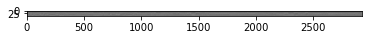

Lasso predicts 0.66 for case 83.0 with 0.84 with regularization 0.004197594092584625 with reconstruction error 0.001357232 maximum error 0.015640124 and neighbor 0.66


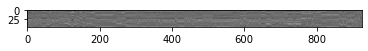

Lasso predicts 0.42 for case 62.0 with 0.47 with regularization 3.917737812114129e-06 with reconstruction error 0.000655373 maximum error 0.000961028 and neighbor 0.43


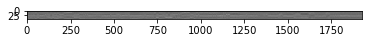

Lasso predicts 0.37 for case 87.0 with 0.09 with regularization 0.0007236341257154057 with reconstruction error 0.0185916 maximum error 0.005545728 and neighbor 0.19


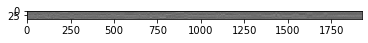

Lasso predicts 0.65 for case 58.0 with 0.52 with regularization 2.3408193480790326e-05 with reconstruction error 5.8381e-05 maximum error 9.5838e-05 and neighbor 0.47


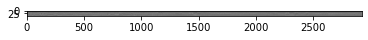

Lasso predicts 0.15 for case 89.0 with 0.36 with regularization 0.01560114326286878 with reconstruction error 0.152893546 maximum error 0.050268941 and neighbor 0.15


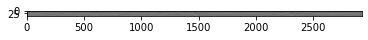

Lasso predicts 0.55 for case 78.0 with 0.82 with regularization 0.0012204276336647204 with reconstruction error 0.008318573 maximum error 0.004736531 and neighbor 0.19


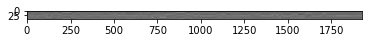

Lasso predicts 0.34 for case 90.0 with 0.3 with regularization 0.002029891262245878 with reconstruction error 0.010383799 maximum error 0.008651814 and neighbor 0.53


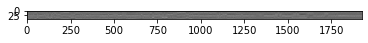

Lasso predicts 0.62 for case 61.0 with 0.85 with regularization 0.003826264501068394 with reconstruction error 0.024138424 maximum error 0.014528843 and neighbor 0.88


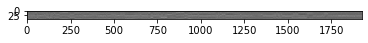

Lasso predicts 0.65 for case 1.0 with 0.83 with regularization 0.0009375653043508719 with reconstruction error 0.005874831 maximum error 0.003726556 and neighbor 0.19


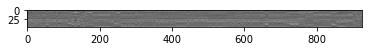

Lasso predicts 0.69 for case 2.0 with 0.91 with regularization 0.0018540171318159092 with reconstruction error 0.000391798 maximum error 0.007517378 and neighbor 0.74


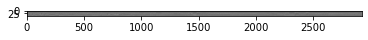

Lasso predicts 0.54 for case 3.0 with 0.56 with regularization 0.01613356388112346 with reconstruction error 0.068330116 maximum error 0.054481587 and neighbor 0.52


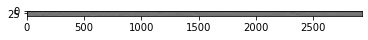

Lasso predicts 0.85 for case 6.0 with 0.95 with regularization 0.0005304391388022536 with reconstruction error 0.0020135 maximum error 0.002077344 and neighbor 0.56


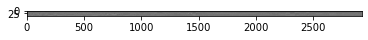

Lasso predicts 0.66 for case 9.0 with 0.89 with regularization 0.015283675319608675 with reconstruction error 0.018722174 maximum error 0.051325855 and neighbor 0.7


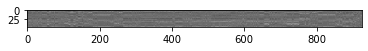

Lasso predicts 0.58 for case 10.0 with 0.59 with regularization 8.523688520993818e-05 with reconstruction error 0.000225884 maximum error 0.000366275 and neighbor 0.69


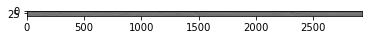

Lasso predicts 0.67 for case 11.0 with 0.74 with regularization 0.011700812186378853 with reconstruction error 0.054679831 maximum error 0.042133029 and neighbor 0.83


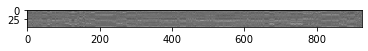

Lasso predicts 0.52 for case 12.0 with 0.5 with regularization 0.0006737171112517863 with reconstruction error 0.0061441 maximum error 0.002774861 and neighbor 0.09


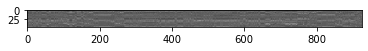

Lasso predicts 0.77 for case 13.0 with 0.7 with regularization 3.3406798469343776e-05 with reconstruction error 0.000313106 maximum error 0.000145879 and neighbor 0.09


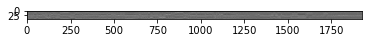

Lasso predicts 0.66 for case 15.0 with 0.69 with regularization 0.009303401885133546 with reconstruction error 0.002655967 maximum error 0.03390582 and neighbor 0.59


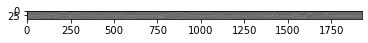

Lasso predicts 0.7 for case 16.0 with 0.88 with regularization 0.003012246556232318 with reconstruction error 0.00825511 maximum error 0.01234889 and neighbor 0.69


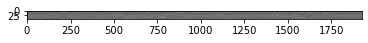

Lasso predicts 0.68 for case 20.0 with 0.67 with regularization 1.463787059399903e-15 with reconstruction error 0.0 maximum error 0.0 and neighbor 0.48


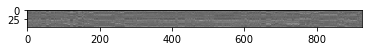

Lasso predicts 0.82 for case 25.0 with 0.7 with regularization 0.004465958162484456 with reconstruction error 0.012324214 maximum error 0.021426298 and neighbor 0.85


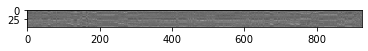

Lasso predicts 0.79 for case 26.0 with 0.88 with regularization 0.001324104733265985 with reconstruction error 0.016128894 maximum error 0.005192448 and neighbor 0.15


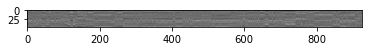

Lasso predicts 0.32 for case 27.0 with 0.74 with regularization 0.0022937986238626856 with reconstruction error 0.017998413 maximum error 0.009886023 and neighbor 0.88


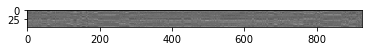

Lasso predicts 0.49 for case 29.0 with 0.8 with regularization 0.002927272573640323 with reconstruction error 0.030457649 maximum error 0.010761321 and neighbor 0.15


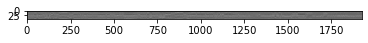

Lasso predicts 0.59 for case 32.0 with 0.67 with regularization 0.008868791243331764 with reconstruction error 0.01444551 maximum error 0.031390486 and neighbor 0.56


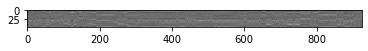

Lasso predicts 0.73 for case 34.0 with 0.69 with regularization 2.9486647042182613e-15 with reconstruction error 0.0 maximum error 0.0 and neighbor 0.43


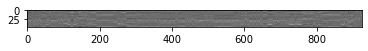

Lasso predicts 0.49 for case 41.0 with 0.43 with regularization 0.0015827981134811887 with reconstruction error 0.00371821 maximum error 0.006038985 and neighbor 0.48


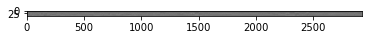

Lasso predicts 0.25 for case 44.0 with 0.19 with regularization 0.00380860157276547 with reconstruction error 0.047111934 maximum error 0.01498658 and neighbor 0.09


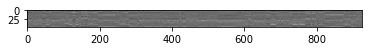

Lasso predicts 0.59 for case 45.0 with 0.94 with regularization 3.57450892247303e-15 with reconstruction error 0.000451902 maximum error 0.001396578 and neighbor 0.43


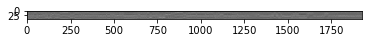

Lasso predicts 0.52 for case 46.0 with 0.56 with regularization 1.3552460435935113e-14 with reconstruction error 0.0 maximum error 0.0 and neighbor 0.43


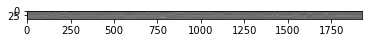

Lasso predicts 0.56 for case 52.0 with 0.67 with regularization 5.552902587993454e-05 with reconstruction error 0.002241009 maximum error 0.001215455 and neighbor 0.15


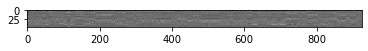

Lasso predicts 0.83 for case 54.0 with 0.87 with regularization 0.001537734079949333 with reconstruction error 0.004053073 maximum error 0.006632515 and neighbor 0.59


In [9]:
Js = []
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]
    y_cat = y_train > 0.3
   
    
    # Cross validation
    cvn = 6
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,test_index,pre_updrs_off,ledd,False,False,False)
    lasso = slm.LassoLarsCV(max_iter=1000,cv=cvn,normalize=False,eps=0.1,n_jobs=1)

    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
      # Feature selection
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      sel = skf.SelectKBest(skf.r_regression,k=2925)
      X0_sst = sel.fit_transform(X0_ss0,y_train)
      X_test_sst = sel.transform(X_test_ss0)
      gel = skf.RFECV(lasso,verbose=0,cv=cvn,step=1000,n_jobs=1)
      X0_ss = gel.fit_transform(X0_sst,y_train)
      
      X_test_ss = gel.transform(X_test_sst)
     #Ks.append(sel.transform(K.reshape(1, -1)))
      dx, y_n = cKDTree(X0_ss).query(X_test_ss, k=1)
      plt.imshow(X0_ss,cmap="gray")
      plt.show()


    # LASSO
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=cvn,n_jobs=1,normalize=False,eps=0.1)
      est_ls = lasso.fit(X0_ss,y_train)
    # Reconstruct nearest neighbor
    r[j] = est_ls.predict(X0_ss[y_n,:])
    err_var[j] = np.mean(abs(est_ls.predict(X0_ss)-y_train))
    rerror[j] = np.abs(r[j]-y_train[y_n])
    #s.append(est_ls.score(X0_ss,y_train))
    results_ls[j] = est_ls.predict(X_test_ss)
    # If reconstruction error is too high, use nearest neighbor
    if rerror[j] > 0.1:
      results_ls[j] = y_train[y_n]

    else:
      # LASSO
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=cvn,n_jobs=1,normalize=False,eps=0.1)
        est_ls = lasso.fit(X0_ss,y_train)
      # Reconstruct nearest neighbor
      r[j] = est_ls.predict(X0_ss[y_n,:])
      err_var[j] = np.mean(abs(est_ls.predict(X0_ss)-y_train))
      rerror[j] = np.abs(r[j]-y_train[y_n])
      #s.append(est_ls.score(X0_ss,y_train))
      results_ls[j] = est_ls.predict(X_test_ss)
        #results_ls[j] = r[j]
      w.append(est_ls.coef_)
    print('Lasso predicts',str(np.round(results_ls[j],2)),
              'for case',str(subsc[j]),'with',str(np.round(per_change[j],2)),
              'with regularization',str(est_ls.alpha_),
              'with reconstruction error',str(np.round(rerror[j],9)),
              'maximum error',str(np.round(err_var[j],9)),
              'and neighbor',str(np.round(y_train[y_n],2).item()))
    gerror[j] = (abs(results_ls[j]-y_test))
        
    if gerror[j] > 0.15:
          pcases.append(test_id)
          pscores.append(s)
  


Text(0.5, 1.0, 'Error estimation')

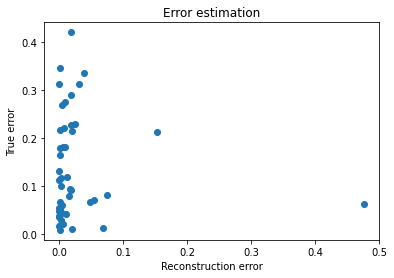

In [10]:
plt.scatter(rerror,gerror)
plt.xlabel('Reconstruction error')
plt.ylabel('True error')
plt.title('Error estimation')

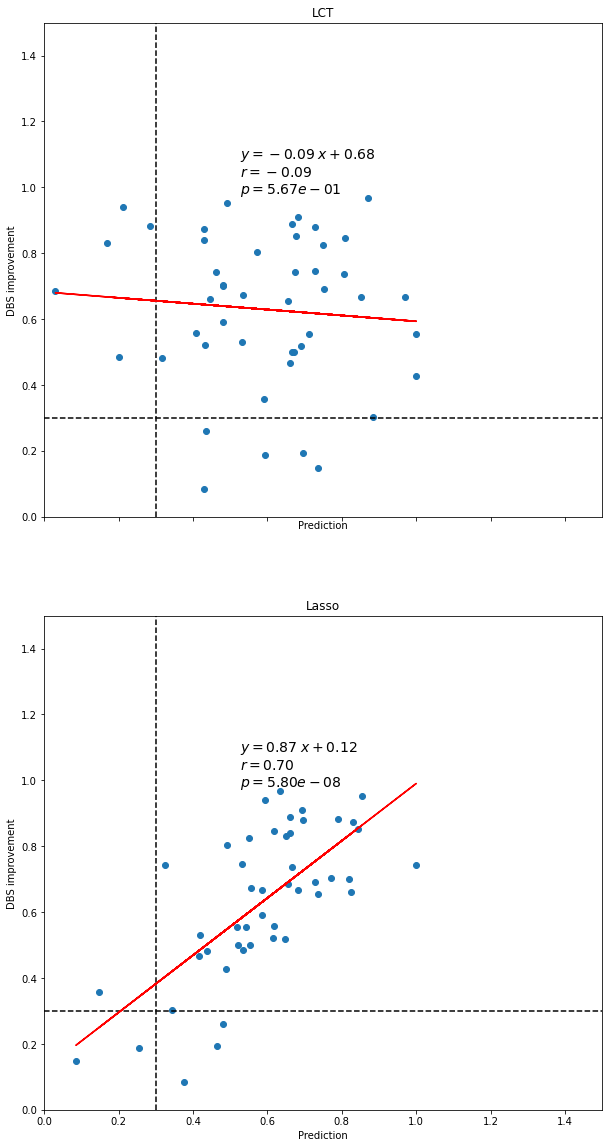

In [11]:
results_ls[results_ls>1] = 1
util.eval_prediction(np.vstack((pre_imp,
                               results_ls,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                ],(20,10))
plt.ylim([0,1.5])
plt.xlim([0,1.5])
plt.style.use('default')